In [25]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [31]:
df = pd.read_csv('fake_reviews_dataset.csv')
df.head()

,category,rating,text,label
0,Home_and_Kitchen,5.0,"Love this! Well made, sturdy, and very comfor...",1
1,Home_and_Kitchen,5.0,"love it, a great upgrade from the original. I...",1
2,Home_and_Kitchen,5.0,This pillow saved my back. I love the look and...,1
3,Home_and_Kitchen,1.0,"Missing information on how to use it, but it i...",1
4,Home_and_Kitchen,5.0,Very nice set. Good quality. We have had the s...,1


In [35]:
from collections import Counter
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd

# Load the dataset
df = pd.read_csv('fake_reviews_dataset.csv')

# Assuming the text column is named 'text'
texts = df['text'].astype(str).tolist()

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Calculate the length of each sequence
sequence_lengths = [len(seq) for seq in sequences]

# Define buckets (0-50, 50-100, ..., 650-700)
buckets = np.arange(0, 750, 50)

# Count the number of sequences in each bucket
bucket_counts = Counter(np.digitize(sequence_lengths, buckets))

# Print the number of reviews in each bucket
for i in range(len(buckets) - 1):
    print(f"{buckets[i]}-{buckets[i+1]}: {bucket_counts[i+1]} reviews")

0-50: 23764 reviews
50-100: 8139 reviews
100-150: 3435 reviews
150-200: 2074 reviews
200-250: 1432 reviews
250-300: 1101 reviews
300-350: 513 reviews
350-400: 61 reviews
400-450: 3 reviews
450-500: 2 reviews
500-550: 2 reviews
550-600: 0 reviews
600-650: 0 reviews
650-700: 0 reviews


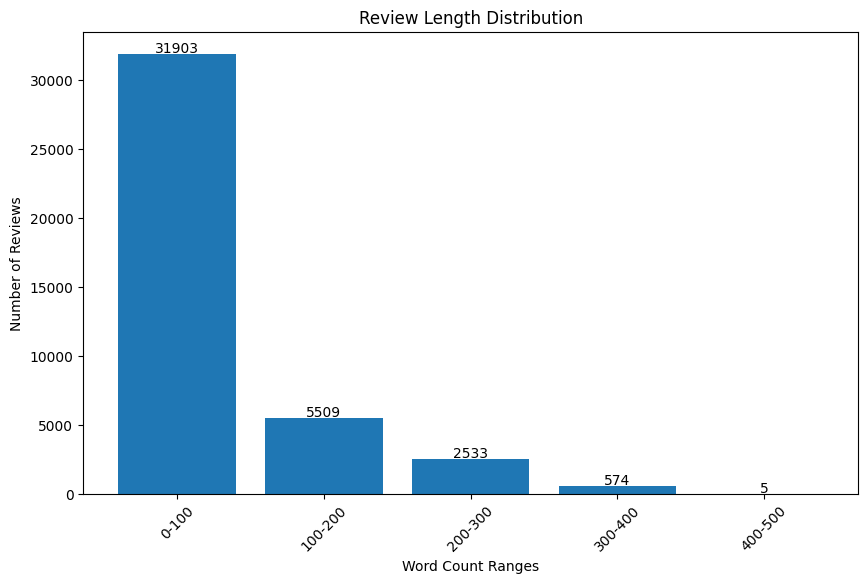

In [42]:
from collections import Counter
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('fake_reviews_dataset.csv')

# Assuming the text column is named 'text'
texts = df['text'].astype(str).tolist()

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Calculate the length of each sequence
sequence_lengths = [len(seq) for seq in sequences]

# Define buckets (0-100, 100-200, ..., 400-500)
buckets = np.arange(0, 600, 100)

# Count the number of sequences in each bucket
bucket_counts = Counter(np.digitize(sequence_lengths, buckets))

# Prepare bucket labels and counts dynamically
bucket_labels = [f"{buckets[i]}-{buckets[i+1]}" for i in range(len(buckets) - 1)]
bucket_values = [bucket_counts[i + 1] for i in range(len(buckets) - 1)]

# Plot the results
plt.figure(figsize=(10, 6))
bars = plt.bar(bucket_labels, bucket_values)

# Add number labels on top of each bar
for bar, count in zip(bars, bucket_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center the text horizontally
        bar.get_height() + 100,  # Position slightly above the bar
        str(count),  # The count as text
        ha="center",  # Align horizontally
        fontsize=10,
    )

# Add titles and labels
plt.title("Review Length Distribution")
plt.xlabel("Word Count Ranges")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.show()

In [27]:
def preprocess_and_split_data(df):
    # Load stop words and initialize stemmer
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    # Preprocessing function: remove stop words and apply stemming
    def preprocess_text(text):
        words = text.split()
        filtered_words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)

    # Split the data into training and testing sets (80% train, 20% test)
    X = df['text']  # Features (text data)
    y = df['label']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply preprocessing to the training and testing sets separately
    X_train = X_train.apply(preprocess_text)
    X_test = X_test.apply(preprocess_text)

    # Tokenize and pad sequences
    max_words = 10000  # Hardcoded maximum number of words
    max_len = 100      # Hardcoded maximum sequence length
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

    # Return the processed datasets and tokenizer
    return X_train_pad, X_test_pad, y_train, y_test, tokenizer

In [28]:
# Example usage for preprocessing
X_train, X_test, y_train, y_test, tokenizer = preprocess_and_split_data(df)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (32420, 100) (32420,)
Test shape: (8106, 100) (8106,)


In [29]:
# Check class distribution in training and testing sets
import numpy as np

# Calculate class distribution
train_class_distribution = np.bincount(y_train)
test_class_distribution = np.bincount(y_test)

# Print class distribution
print("Class distribution in training set:", train_class_distribution)
print("Class distribution in testing set:", test_class_distribution)

# Calculate percentages for better understanding
train_class_percentage = train_class_distribution / len(y_train) * 100
test_class_percentage = test_class_distribution / len(y_test) * 100

print("Class percentages in training set:", train_class_percentage)
print("Class percentages in testing set:", test_class_percentage)

Class distribution in training set: [16201 16219]
Class distribution in testing set: [4031 4075]
Class percentages in training set: [49.97223936 50.02776064]
Class percentages in testing set: [49.7285961 50.2714039]


In [30]:
# Example of how to use the preprocessed data for a simple LSTM model

# Simple LSTM model for testing
model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=100),  # Smaller embedding dimension for simplicity
    LSTM(32),  # Fewer units in the LSTM layer
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training after 3 epochs with no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with early stopping
history = model.fit(
    X_train,
    y_train,
    epochs=20,  # Set a high number of epochs; early stopping will terminate earlier if needed
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]  # Add the early stopping callback
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Predict if a new review is fake or real
def predict_review(review, tokenizer, max_len=100):
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    words = review.split()
    filtered_words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]
    preprocessed_review = ' '.join(filtered_words)
    review_seq = tokenizer.texts_to_sequences([preprocessed_review])  # Tokenize the review
    review_pad = pad_sequences(review_seq, maxlen=max_len, padding='post')  # Pad the sequence
    prediction = model.predict(review_pad)
    return "Fake Review" if prediction[0] > 0.5 else "Real Review"

# Example usage
example_review = "This product is amazing and works perfectly!"
print("Prediction:", predict_review(example_review, tokenizer))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.5115 - loss: 0.6936 - val_accuracy: 0.6798 - val_loss: 0.6140
Epoch 2/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6763 - loss: 0.6089 - val_accuracy: 0.6521 - val_loss: 0.5851
Epoch 3/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6853 - loss: 0.5646 - val_accuracy: 0.7565 - val_loss: 0.5250
Epoch 4/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7619 - loss: 0.5201 - val_accuracy: 0.7850 - val_loss: 0.4611
Epoch 5/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.7900 - loss: 0.4661 - val_accuracy: 0.7822 - val_loss: 0.4888
Epoch 6/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.7926 - loss: 0.4636 - val_accuracy: 0.8105 - val_loss: 0.4353
Epoch 7/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.8251 - loss: 0.4031 - val_accuracy: 0.8282 - val_loss: 0.3966
Epoch 8/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.8790 - loss: 0.3066 - 